In [32]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from src.utils.load_dataframe import load_time_series_60min

from src.utils.load_dataframe import load_time_series_60min


In [33]:
# Load the dataset
df = load_time_series_60min()
# Convert index to datetime explicitly to ensure correct format
df.index = pd.to_datetime(df.index, utc=True)
df_numeric = df.select_dtypes(include=[np.number]) # select numeric columns only (exclude datetime)
df = df_numeric.resample('D').mean() # Resample to daily frequency and take the mean value for the day
print("Timestamp datatype:", df.index.dtype)  # Should show datetime64

Timestamp datatype: datetime64[ns, UTC]


In [34]:
# Select the target variable and exogenous variables
target_column:str = 'DE_load_actual_entsoe_transparency'
# Adjusted exogenous variables based on available columns
exogenous_variables:list[str] = [
'DE_solar_generation_actual',    # Solar generation for Germany
# 'DE_wind_onshore_generation_actual',  # Wind generation for Germany
'FR_load_actual_entsoe_transparency',  # Load from France
'NL_load_actual_entsoe_transparency',  # Load from Netherlands
# 'AT_price_day_ahead'  # Price day ahead for Austria (as a proxy for price)
]

In [35]:
def process_data(df:DataFrame, target_column:list[str], exogenous_variables: list[str]) -> DataFrame:
    """
    Prepares the dataset by removing NaN values in the target column and interpolating missing values in exogenous variables.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the time series data.
    target_column (str): The name of the target column (dependent variable).
    exogenous_variables (list of str): A list of exogenous variables (independent variables).

    Returns:
    pd.DataFrame: The processed dataframe with no NaN values in the target column and interpolated exogenous variables.
    """
    
    # Remove rows with NaN values only in the target column
    df = df[[target_column] + exogenous_variables].dropna(subset=[target_column])

    # Interpolate missing values in the exogenous variables
    df[exogenous_variables] = df[exogenous_variables].interpolate(method='time')

    # Fill any remaining NaN values at the beginning or end of the exogenous variables columns
    df[exogenous_variables] = df[exogenous_variables].bfill().ffill()
    return df


In [36]:
df = process_data(df, target_column, exogenous_variables)

# Define target and exogenous variables
y = df[target_column]
X = df[exogenous_variables]

In [56]:
correlation_matrix = df.corr()
print(correlation_matrix[target_column])

DE_load_actual_entsoe_transparency    1.000000
DE_solar_generation_actual           -0.358442
DE_wind_onshore_generation_actual     0.189355
FR_load_actual_entsoe_transparency    0.664490
NL_load_actual_entsoe_transparency    0.821234
AT_price_day_ahead                    0.234057
Name: DE_load_actual_entsoe_transparency, dtype: float64


In [37]:
def check_stationarity(series: pd.Series):
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    
    if adf_result[1] > 0.05:
        print("The series is non-stationary. Applying Box-Cox transformation...")
        series_transformed, lam = boxcox(series)
        return series_transformed, lam
    else:
        print("The series is stationary. No transformation needed.")
        return series, None

In [38]:
# Check stationarity and apply Box-Cox if needed
y_transformed, lam = check_stationarity(y)

ADF Statistic: -4.593460971848542
p-value: 0.00013280221269337063
The series is stationary. No transformation needed.


<Figure size 1000x600 with 0 Axes>

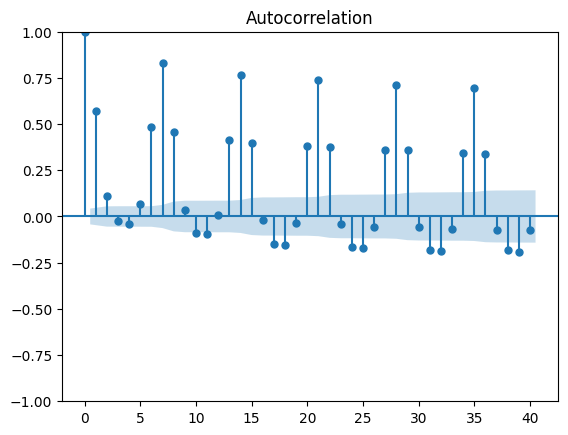

<Figure size 1000x600 with 0 Axes>

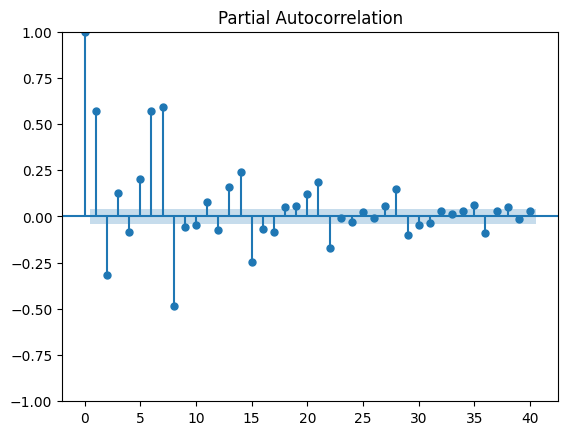

In [39]:
# Visualize ACF and PACF for the target variable
plt.figure(figsize=(10, 6))
plot_acf(y_transformed, lags=40)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(y_transformed, lags=40)
plt.show()


In [40]:
# 3. Scaling (optional): Scale the exogenous variables if necessary
scaler = RobustScaler()


In [41]:
# Split data into train and test sets (80% train, 20% test)
print(f"Original data size: {len(df)}")
train_size = int(0.8 * len(df))
train_y, test_y = y_transformed[:train_size], y_transformed[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

Original data size: 2100


In [42]:
# Scale exogenous variables after splitting
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)
print(f"Train size: {len(train_y)}, Test size: {len(test_y)}")

Train size: 1680, Test size: 420


In [43]:
# Use auto_arima from pmdarima to get initial best parameters
print("Running auto_arima for initial parameter search...")
auto_model = pm.auto_arima(train_y,
                            exogenous_variables=train_X_scaled,
                            seasonal=True,
                            m=24,
                            stepwise=True,
                            trace=True,
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            start_P=0, max_P=3,
                            start_Q=0, max_Q=3,
                            max_d=1, max_D=1,
                            suppress_warnings=True,
                            # max_order=3,
                            error_action='ignore',
                            # n_jobs=5, Parallel processing is disabled due incompatibility with Stepwise search
                            # method="nm",
                            # information_criterion='bic',
                        )

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"Best order: {best_order}, Best seasonal order: {best_seasonal_order}")

Running auto_arima for initial parameter search...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=34107.457, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=34076.604, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=33822.163, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=34105.459, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=34101.813, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=33768.294, Time=1.09 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=33747.016, Time=1.86 sec
 ARIMA(0,1,1)(2,0,0)[24] intercept   : AIC=33723.317, Time=7.63 sec
 ARIMA(0,1,1)(3,0,0)[24] intercept   : AIC=33896.536, Time=5.29 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=33766.536, Time=3.92 sec
 ARIMA(0,1,1)(3,0,1)[24] intercept   : AIC=33668.277, Time=11.58 sec
 ARIMA(0,1,1)(3,0,2)[24] intercept   : AIC=inf, Time=23.47 sec
 ARIMA(0,1,1)(2,0,2)[24] intercept   : AIC=33733.682, Time=10.34 sec
 ARIMA(0,1,0)(3,0,1)[24] 

In [44]:
# Ensure consistent datetime index and timezone (if necessary)
train_y.index = pd.to_datetime(train_y.index, utc=True)
test_y.index = pd.to_datetime(test_y.index, utc=True)
# Fit SARIMAX with auto_arima parameters
sarimax_model = SARIMAX(train_y, exog=train_X_scaled, order=best_order, seasonal_order=best_seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

                                       SARIMAX Results                                        
Dep. Variable:     DE_load_actual_entsoe_transparency   No. Observations:                 1680
Model:                 SARIMAX(2, 1, 1)x(3, 0, 1, 24)   Log Likelihood              -15057.202
Date:                                Sat, 14 Sep 2024   AIC                          30140.403
Time:                                        23:13:06   BIC                          30210.940
Sample:                                    01-01-2015   HQIC                         30166.533
                                         - 08-07-2019                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -60.5867    107.638     -0.563      0.574    -271.553     150.380
x2 

In [52]:
# Make predictions on the test set
predictions = sarimax_result.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X_scaled)

In [54]:
if 'lam' in locals() and lam is not None:
    predictions = np.exp(np.log(predictions * lam + 1) / lam) 
    test_y = np.exp(np.log(test_y * lam + 1) / lam)


MSE: 62629123.50043789
RMSE: 7913.856424047501
MAE: 5842.865977742527
R2: -0.4331747579505605
MAPE: 10.73513350160954%
Accuracy: 38.80952380952381% with a tolerance of 5%


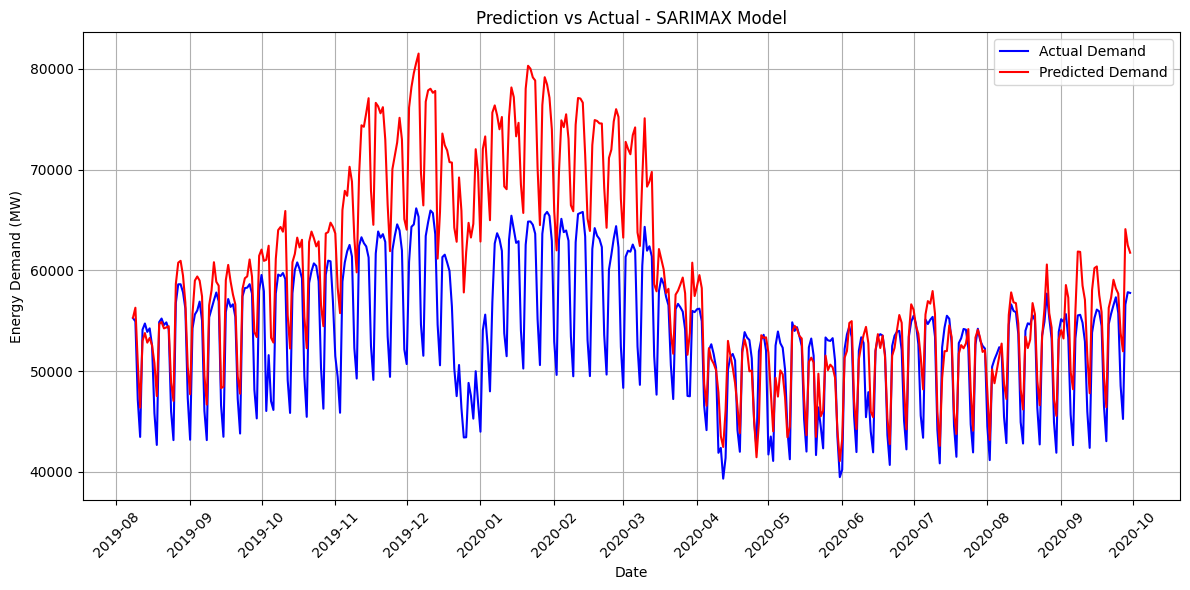

In [55]:
import importlib
import src.utils.conclusion_metrics
import src.utils.plotting
importlib.reload(src.utils.conclusion_metrics)
from src.utils.conclusion_metrics import calculate_all_metrics
importlib.reload(src.utils.plotting)
from src.utils.plotting import plot_predictions
# 7. Calculate metrics: MSE,  RMSE, MAE, R2, MAPE
test_dates = df.index[-len(test_y):]
calculate_all_metrics(y_true=test_y, y_pred=predictions)
plot_predictions( test_y, predictions, test_dates, 'Prediction vs Actual - SARIMAX Model')


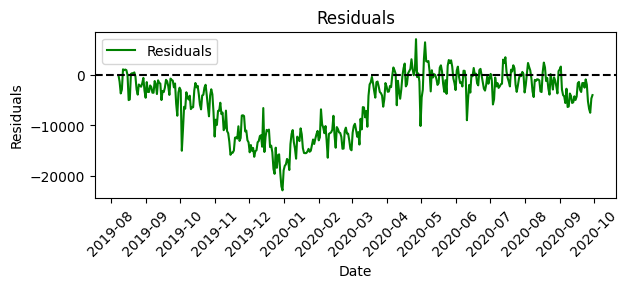

In [51]:
from src.utils.plotting import plot_residuals
residuals = test_y - predictions
plot_residuals(test_dates, residuals)